In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# .kaggle klasörünü oluştur
os.makedirs('/root/.kaggle', exist_ok=True)

# kaggle.json dosyasını doğru yere kopyala
!cp /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle/

# Dosya izinlerini ayarla
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mgunerengineer/istanbul-rent-flat-data

Dataset URL: https://www.kaggle.com/datasets/mgunerengineer/istanbul-rent-flat-data
License(s): DbCL-1.0
  0% 0.00/760k [00:00<?, ?B/s]
100% 760k/760k [00:00<00:00, 896MB/s]


In [4]:
import zipfile

with zipfile.ZipFile('istanbul-rent-flat-data.zip', 'r') as zip_ref:
    zip_ref.extractall('istanbul_rent_data')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [10]:
df = pd.read_csv("istanbul_rent_data/22_9_2022_sahibinden_ev_kira.csv")
# İlk 5 satıra bakalım
df.head()

,Unnamed: 0,title,area,numberOfRooms,price,town,district
0,0,"Tepeköyde Full Eşyalı, 2+1 Bahçe katı Daire",110.0,2+1,15.000,Büyükada,Maden Mh.
1,1,BURGAZADADA FULL EŞYALI 2+1 KİRALIK DAİRE,80.0,2+1,7.500,Burgazada,Burgazada Mh.
2,2,HEYBELİADA'DA 1 EKIM -15 MAYIS KİRALIK BAHÇEKATI,120.0,2+1,8.000,Heybeliada,NaN
3,3,Adalar Kınalı Ada Dublex Full Deniz Manzaralı ...,130.0,3+1,15.000,Kınalıada,Kınalıada Mh.
4,4,HEYBELİADA'DA 3+1 DUBLEKS EŞYALI KİRALIK DAİRE,110.0,3+1,8.500,Heybeliada,NaN


In [11]:
df.isnull().sum()

,0
Unnamed: 0,0
title,0
area,0
numberOfRooms,0
price,0
town,0
district,1001


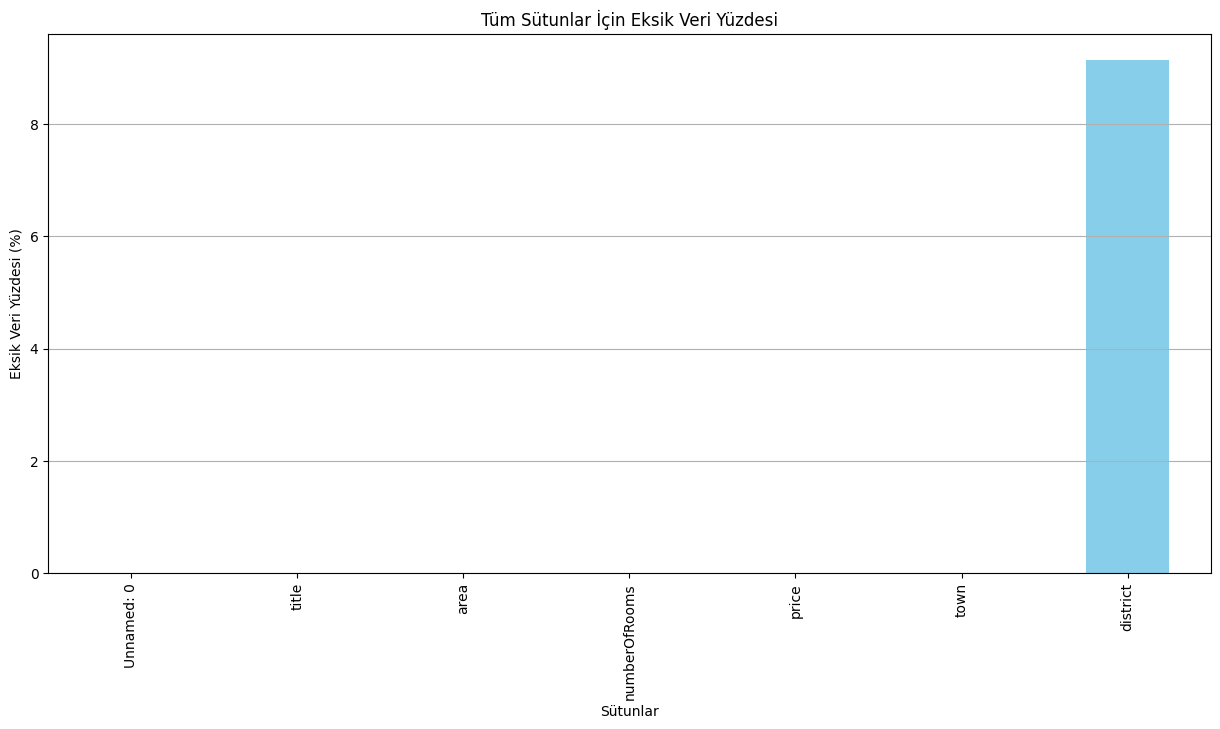

In [12]:
# Eksik değer yüzdesi (tüm sütunlar için)
missing_percent = (df.isnull().sum() / len(df)) * 100

plt.figure(figsize=(15,7))
missing_percent.sort_values().plot.bar(color='skyblue')
plt.title('Tüm Sütunlar İçin Eksik Veri Yüzdesi')
plt.ylabel('Eksik Veri Yüzdesi (%)')
plt.xlabel('Sütunlar')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


In [13]:
# district boş olan satırları filtrele
missing_district = df[df['district'].isnull()]

# bu satırlardaki town değerlerine bakalım
print(missing_district['town'].value_counts())

town
Barbaros        170
Maltepe          91
Yakuplu          88
Kartaltepe       65
Mahmutbey        56
Tarabya          56
Bulgurlu         50
Cihangir         45
Esenevler        41
Zuhuratbaba      33
Atakent          31
Cevizlik         23
Altunizade       22
Tozkoparan       20
Haznedar         18
Ferah            18
Zeytinlik        18
Yedikule         15
Esentepe         14
Emirgan          14
Merkezefendi     13
Fulya            13
Kandilli         12
Cumhuriyet       12
Selimiye         12
Heybeliada       10
Beylerbeyi        9
Bolluca           7
Ihlamurkuyu       6
Bozkurt           5
Sanayi            3
Harbiye           3
Duatepe           3
Kuzguncuk         3
Topselvi          2
Name: count, dtype: int64


In [ ]:
#Buradaki amaç, district sütununda boş yani NaN olan değerlerin hangi town satırlarına karşılık geldiği.
#İlk önceki hedefimiz bir model eğitip o  doldurmaktı ama örneğin Barbaros'ta olmayan bir mahalle ismini ilgili district'e atıyabilir.
# Bu sebeple en doğru karar olarak boş olan sütunlara Merkez Mah atamaya karar verdik.

In [ ]:
# district boş (NaN) olan yerlere "Merkez Mah" atıyoruz
df['district'] = df['district'].fillna('Merkez Mah')

In [15]:
df.isnull().sum()

,0
Unnamed: 0,0
title,0
area,0
numberOfRooms,0
price,0
town,0
district,0


In [ ]:
# 2+1 gibi değerleri total oda sayısına çevirelim ve yeni değerlerini atayalım.
def rooms_to_num(x):
    parts = x.split('+')
    total = 0
    for p in parts:
        try:
            total += int(p)
        except:
            pass
    return total

df['numberOfRooms'] = df['numberOfRooms'].apply(rooms_to_num)

In [17]:
df.head()

,Unnamed: 0,title,area,numberOfRooms,price,town,district
0,0,"Tepeköyde Full Eşyalı, 2+1 Bahçe katı Daire",110.0,3,15.000,Büyükada,Maden Mh.
1,1,BURGAZADADA FULL EŞYALI 2+1 KİRALIK DAİRE,80.0,3,7.500,Burgazada,Burgazada Mh.
2,2,HEYBELİADA'DA 1 EKIM -15 MAYIS KİRALIK BAHÇEKATI,120.0,3,8.000,Heybeliada,Merkez Mah
3,3,Adalar Kınalı Ada Dublex Full Deniz Manzaralı ...,130.0,4,15.000,Kınalıada,Kınalıada Mh.
4,4,HEYBELİADA'DA 3+1 DUBLEKS EŞYALI KİRALIK DAİRE,110.0,4,8.500,Heybeliada,Merkez Mah


In [18]:
# Tahmin edeceğimiz olan price sütununda sayısal değer dışında herhangi bir değer var olup olmadığını kontrol edelim.
non_numeric_prices = df[~df['price'].str.replace('.', '', regex=False).str.isdigit()]
print(non_numeric_prices['price'].unique())

['Üzeri']


In [19]:
# 'price' sütununda 'Üzeri' olan satırları seç
uzeri_satirlar = df[df['price'] == 'Üzeri']
uzeri_sayisi = df[df['price'] == 'Üzeri'].shape[0]
print(uzeri_satirlar)
print(f"'Üzeri' ifadesi {uzeri_sayisi} satırda var.")

      Unnamed: 0                                              title   area  \
362          362  BAYAN APART EŞYALI FATURALAR DAHİL ACIKLAMAYI ...  20.00   
2124        2124   SECRET house'dan 4 katlı işyerine uygun müstakil   1.55   
2227        2227  KAYALARDAN FLORYA KOMPLE 1500 metre² ASANSÖRLÜ...   1.50   
6393        6393  BAYAN APARTIMIZ METROYA MARMARAYA ULAŞIMA YAKI...  20.00   

      numberOfRooms  price       town              district  
362              10  Üzeri  İçerenköy         İçerenköy Mh.  
2124             10  Üzeri     Florya         Şenlikköy Mh.  
2227             10  Üzeri     Florya         Şenlikköy Mh.  
6393             10  Üzeri  Rahmanlar   (Atalar)Atalar Mah.  
'Üzeri' ifadesi 4 satırda var.


Görüldüğü gibi, Üzeri ifadesi olan sadece 4 satır var ve bu satırları kaldırırsak modelimizde çok bir etkisi olmayacaktır.

In [20]:
#Üzeri olan satırları silelim
df['price'] = df['price'].replace('Üzeri', None)
df = df.dropna(subset=['price'])

In [21]:
# Noktaları kaldır ve sayıya çevir
df['price'] = df['price'].str.replace('.', '', regex=False).astype(float)

<ipython-input-21-e7e5e6389b68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].str.replace('.', '', regex=False).astype(float)


In [22]:
df.head()

,Unnamed: 0,title,area,numberOfRooms,price,town,district
0,0,"Tepeköyde Full Eşyalı, 2+1 Bahçe katı Daire",110.0,3,15000.0,Büyükada,Maden Mh.
1,1,BURGAZADADA FULL EŞYALI 2+1 KİRALIK DAİRE,80.0,3,7500.0,Burgazada,Burgazada Mh.
2,2,HEYBELİADA'DA 1 EKIM -15 MAYIS KİRALIK BAHÇEKATI,120.0,3,8000.0,Heybeliada,Merkez Mah
3,3,Adalar Kınalı Ada Dublex Full Deniz Manzaralı ...,130.0,4,15000.0,Kınalıada,Kınalıada Mh.
4,4,HEYBELİADA'DA 3+1 DUBLEKS EŞYALI KİRALIK DAİRE,110.0,4,8500.0,Heybeliada,Merkez Mah


In [23]:
# Future Engineering yapalım, yeni sütunlar ve öznitelikler ekleyerek modelimizin performansını arttıralım
# 'deniz manzaralı' ifadesini küçük harfe çevirerek arayalım (büyük-küçük harf duyarsız)
df['deniz_manzarali'] = df['title'].str.lower().str.contains('deniz manzaralı')

# Sonucu kontrol etmek için:
print(df[['title', 'deniz_manzarali']].head())

                                               title  deniz_manzarali
0        Tepeköyde Full Eşyalı, 2+1 Bahçe katı Daire            False
1          BURGAZADADA FULL EŞYALI 2+1 KİRALIK DAİRE            False
2   HEYBELİADA'DA 1 EKIM -15 MAYIS KİRALIK BAHÇEKATI            False
3  Adalar Kınalı Ada Dublex Full Deniz Manzaralı ...             True
4     HEYBELİADA'DA 3+1 DUBLEKS EŞYALI KİRALIK DAİRE            False


In [24]:
#Deniz manzaralı olanları gösterelim.
deniz_manzarali_evler = df[df['deniz_manzarali'] == True]
print(deniz_manzarali_evler)

       Unnamed: 0                                              title   area  \
3               3  Adalar Kınalı Ada Dublex Full Deniz Manzaralı ...  130.0   
8               8  Burgaz adada ful eşyalı sezonlu kiralık deniz ...  140.0   
10             10  Büyükada Kesintisiz Deniz Manzaralı Sezonluk 3...  160.0   
11             11  Kınalıada Da 2023 Sezonluk Eşyalı Deniz Manzar...   90.0   
12             12  Kınalıada Da Yaz-Kış Eşyalı Deniz Manzaralı Ki...   80.0   
...           ...                                                ...    ...   
10702       10702  Büyükyalı Ön Cephe Deniz Manzaralı 4+1&253m2 E...  253.0   
10703       10703  Büyükyalıda Ultra Lüx Eşsiz Deniz Manzaralı Eş...  220.0   
10766       10766  Kiptaş Topkapı Merkezevler 4+1 Eşyalı Peyzaj v...  212.0   
10906       10906  Kiptaş Topkapı Merkezevleri 4+1 Eşyalı Peyzaj ...  213.0   
10944       10944  Coldwell Banker LocaMahal de Kiralık Deniz Man...   73.0   

       numberOfRooms     price          town       

Aykırı Değer Kontrolü

In [25]:
#Aykırı değer kontrolü
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

area_outliers = find_outliers(df['area'])
price_outliers = find_outliers(df['price'])

print("Area Outliers:\n", area_outliers)
print("\nPrice Outliers:\n", price_outliers)


Area Outliers:
 14       250.0
75       250.0
152      270.0
272      550.0
394      270.0
         ...  
10801    450.0
10805    310.0
10825    350.0
10885    350.0
10893    275.0
Name: area, Length: 503, dtype: float64

Price Outliers:
 8         90000.0
11        95000.0
18        40000.0
23        90000.0
27       300000.0
           ...   
10913     65000.0
10916     50000.0
10920     65000.0
10936     35000.0
10937     35000.0
Name: price, Length: 1055, dtype: float64


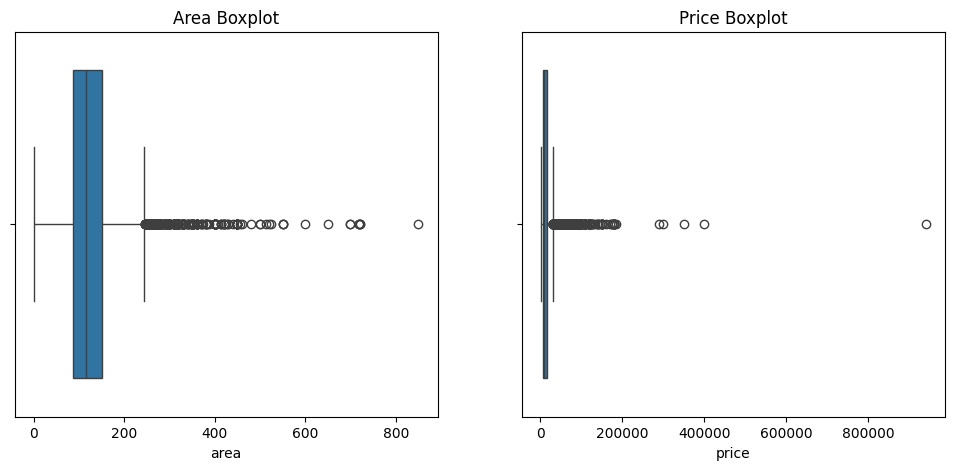

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['area'])
plt.title('Area Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title('Price Boxplot')

plt.show()

In [27]:
Q1_area = df['area'].quantile(0.25)
Q3_area = df['area'].quantile(0.75)
IQR_area = Q3_area - Q1_area
lower_area = Q1_area - 1.5 * IQR_area
upper_area = Q3_area + 1.5 * IQR_area

df['area_capped'] = df['area'].clip(lower=lower_area, upper=upper_area)


Q1_price = df['price'].quantile(0.25)
Q3_price = df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_price = Q1_price - 1.5 * IQR_price
upper_price = Q3_price + 1.5 * IQR_price

df['price_capped'] = df['price'].clip(lower=lower_price, upper=upper_price)

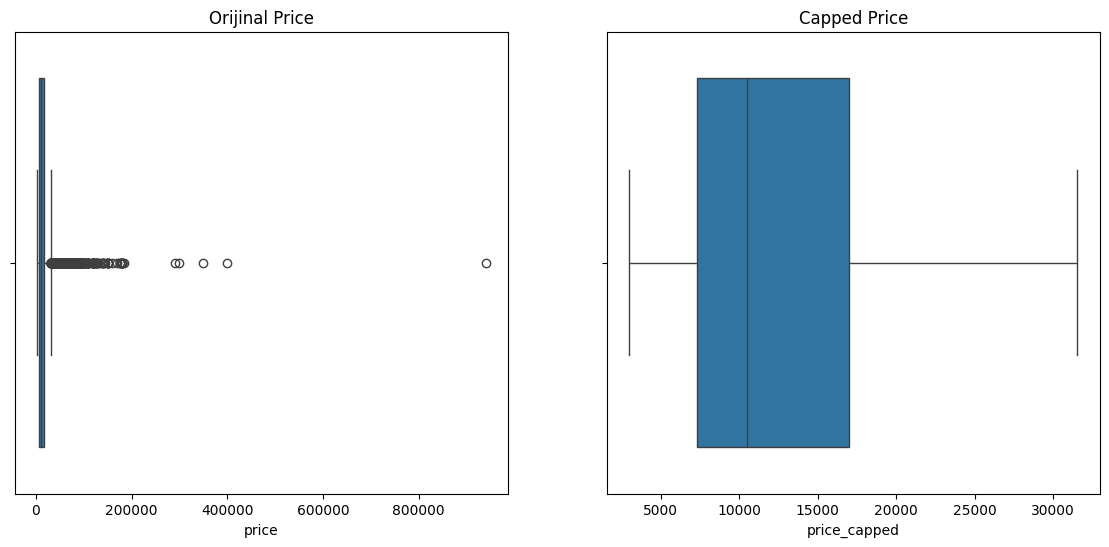

In [28]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['price'])
plt.title('Orijinal Price')

plt.subplot(1,2,2)
sns.boxplot(x=df['price_capped'])
plt.title('Capped Price')

plt.show()

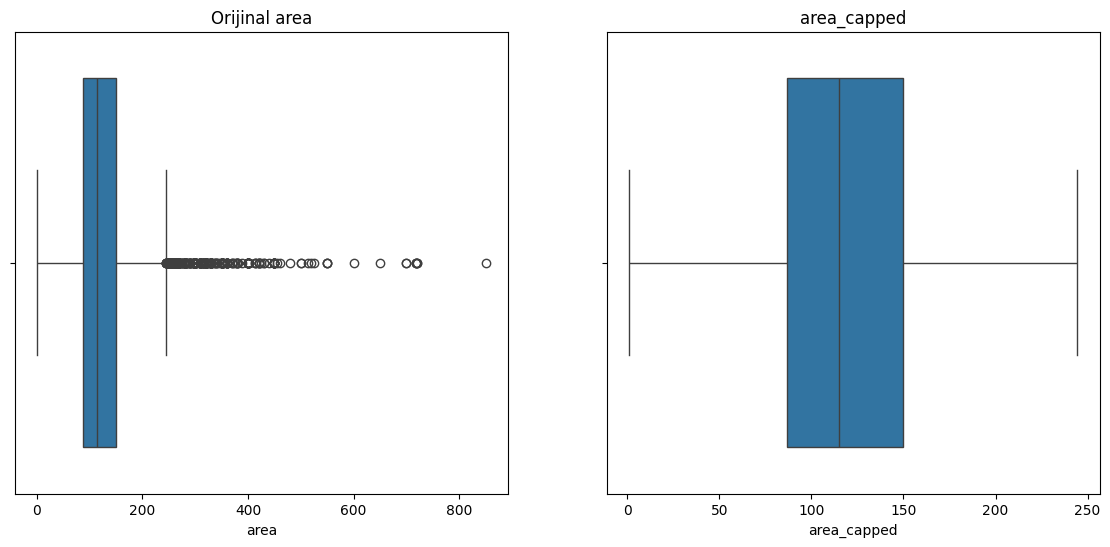

In [29]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['area'])
plt.title('Orijinal area')

plt.subplot(1,2,2)
sns.boxplot(x=df['area_capped'])
plt.title('area_capped')

plt.show()

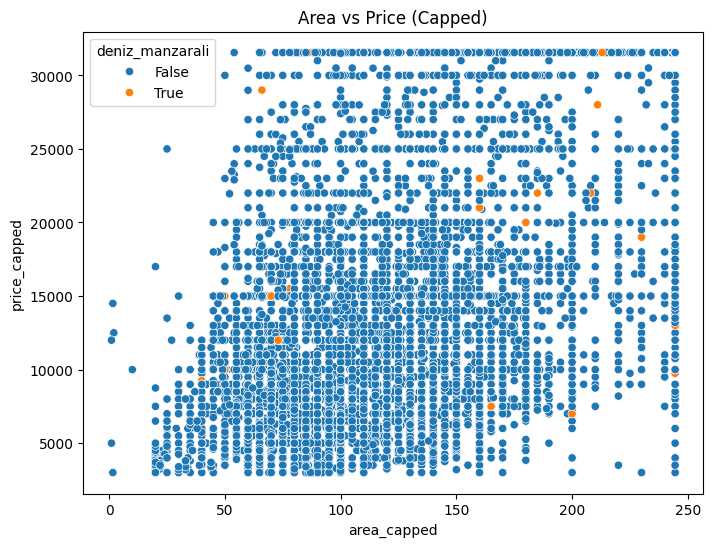

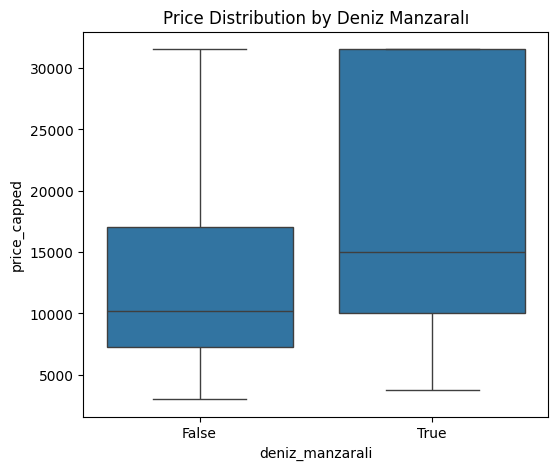

In [30]:
# Alan ve fiyat scatter plot (dağılım)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='area_capped', y='price_capped', hue='deniz_manzarali')
plt.title('Area vs Price (Capped)')
plt.show()

# Deniz manzaralı evlerin fiyat dağılımı (boxplot)
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='deniz_manzarali', y='price_capped')
plt.title('Price Distribution by Deniz Manzaralı')
plt.show()

In [31]:
# town ve district sütunlarında one-hot encoding yapıyoruz
df = pd.get_dummies(df, columns=['town', 'district'], drop_first=True)

In [32]:
df.head()

,Unnamed: 0,title,area,numberOfRooms,price,deniz_manzarali,area_capped,price_capped,town_Abdurrahman,town_Acıbadem,...,district_İzzet Paşa Mh.,district_İzzettin Mh.,district_İçerenköy Mh.,district_Şahkulu Mh.,district_Şehit Muhtar Mh.,district_Şehremini Mh.,district_Şehsuvar Bey Mh.,district_Şemsipaşa Mh.,district_Şenlikköy Mh.,district_Şerifali Mh.
0,0,"Tepeköyde Full Eşyalı, 2+1 Bahçe katı Daire",110.0,3,15000.0,False,110.0,15000.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,BURGAZADADA FULL EŞYALI 2+1 KİRALIK DAİRE,80.0,3,7500.0,False,80.0,7500.0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,HEYBELİADA'DA 1 EKIM -15 MAYIS KİRALIK BAHÇEKATI,120.0,3,8000.0,False,120.0,8000.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,Adalar Kınalı Ada Dublex Full Deniz Manzaralı ...,130.0,4,15000.0,True,130.0,15000.0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,HEYBELİADA'DA 3+1 DUBLEKS EŞYALI KİRALIK DAİRE,110.0,4,8500.0,False,110.0,8500.0,False,False,...,False,False,False,False,False,False,False,False,False,False


One-hot encoding yaptıktan sonra sütun sayımız 558'e çıktı

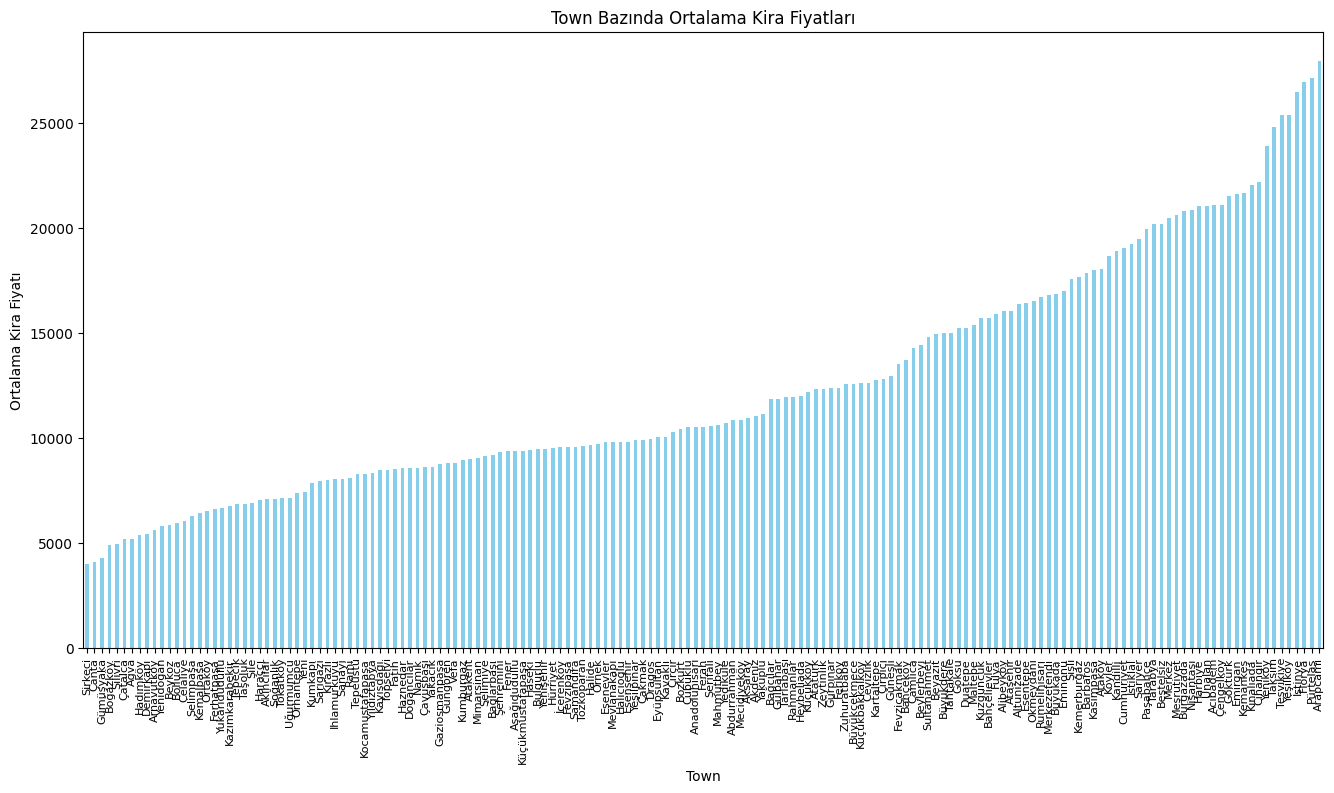

In [33]:
# town sütunlarını seç (town ile başlayan sütunlar)
town_cols = [col for col in df.columns if col.startswith('town_')]

# Her town için ortalama price_capped hesapla
town_avg_price = {}
for town in town_cols:
    # town sütunu True olan satırlarda price_capped ortalaması
    avg_price = df.loc[df[town] == True, 'price_capped'].mean()
    town_avg_price[town.replace('town_', '')] = avg_price

# Sözlüğü DataFrame'e çevir
town_price_df = pd.DataFrame.from_dict(town_avg_price, orient='index', columns=['Average Price']).sort_values('Average Price')

# Görselleştir
plt.figure(figsize=(16,8))
town_price_df['Average Price'].plot(kind='bar', color='skyblue')
plt.title('Town Bazında Ortalama Kira Fiyatları')
plt.ylabel('Ortalama Kira Fiyatı')
plt.xlabel('Town')
plt.xticks(rotation=90, fontsize=8)
plt.show()

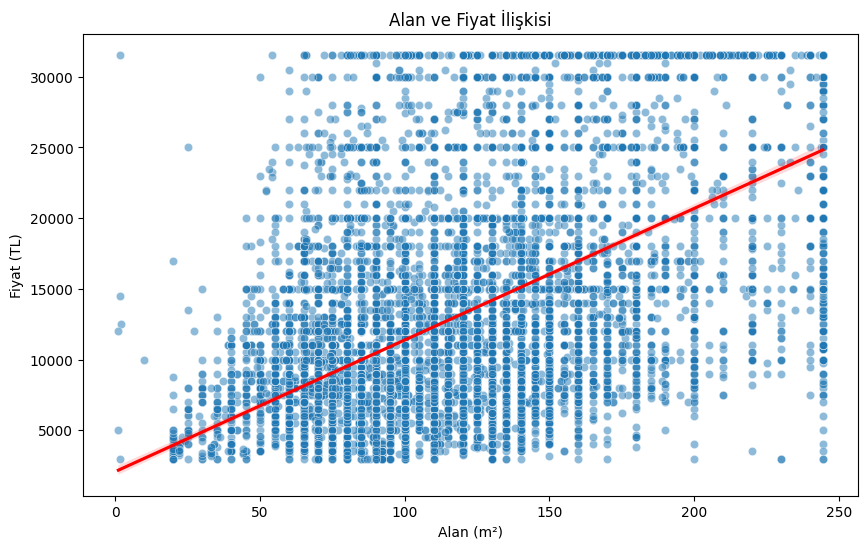

In [34]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='area_capped', y='price_capped', data=df, alpha=0.5)
sns.regplot(x='area_capped', y='price_capped', data=df, scatter=False, color='red')
plt.title('Alan ve Fiyat İlişkisi')
plt.xlabel('Alan (m²)')
plt.ylabel('Fiyat (TL)')
plt.show()

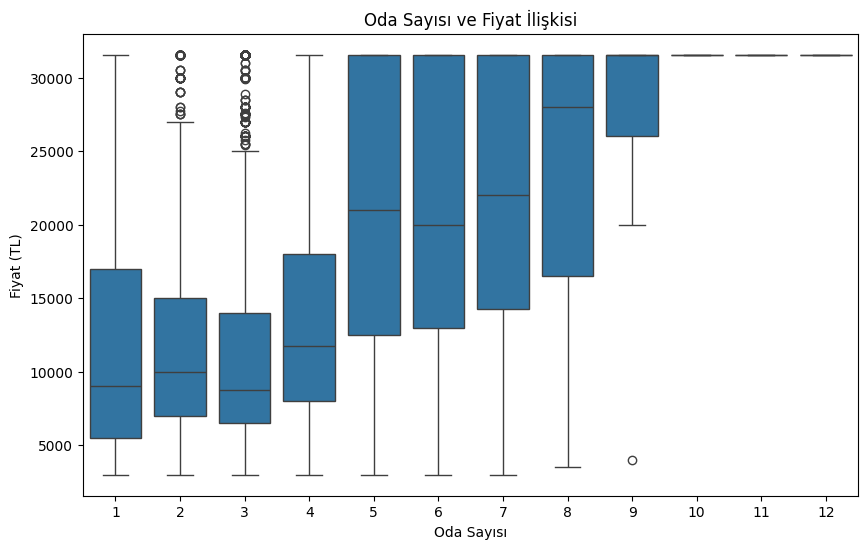

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='numberOfRooms', y='price_capped', data=df)
plt.title('Oda Sayısı ve Fiyat İlişkisi')
plt.xlabel('Oda Sayısı')
plt.ylabel('Fiyat (TL)')
plt.show()

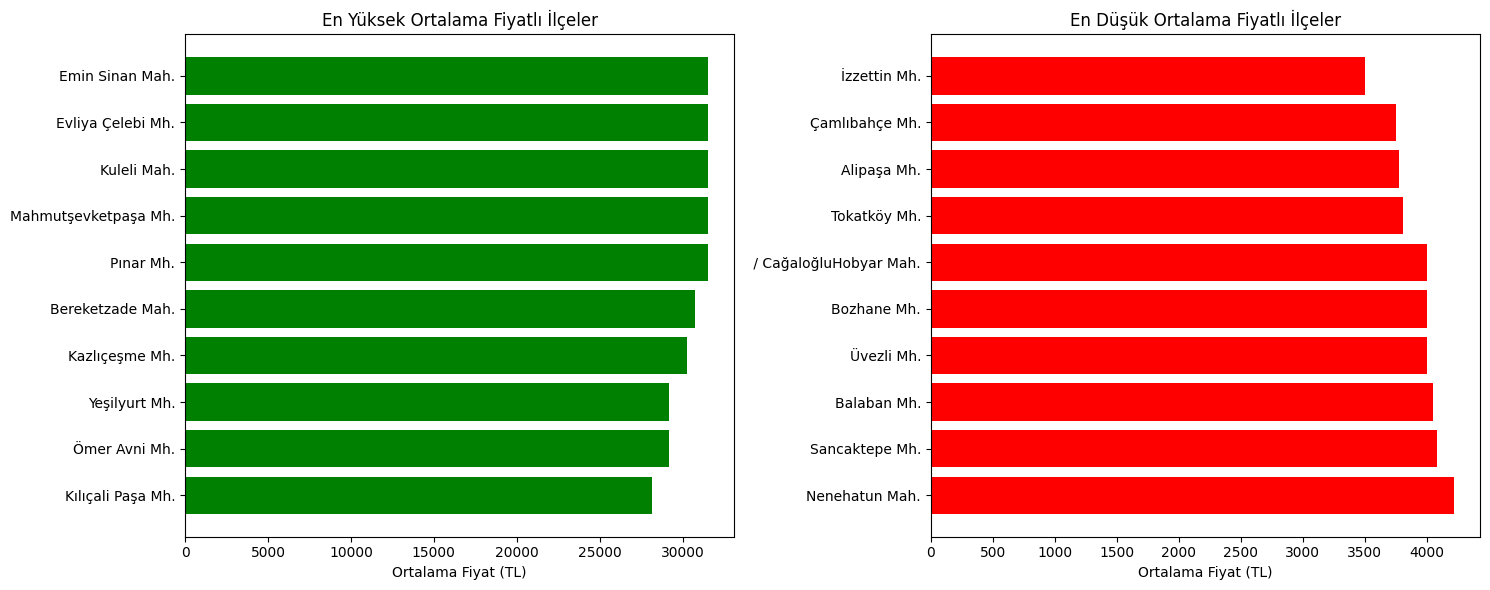

In [36]:
# İlçe sütunları one-hot encode edilmiş, onları toplayıp ortalama fiyatı hesaplayalım
# Önce district kolonlarının isimlerini alalım (district_ ile başlayan)
district_cols = [col for col in df.columns if col.startswith('district_')]

# Her satırda hangi district olduğu 1 ile gösterildiği için, her district için fiyatların ortalamasını alacağız
district_avg_prices = {}

for district in district_cols:
    # O ilçeye ait olan satırların fiyat ortalaması
    avg_price = df.loc[df[district] == True, 'price_capped'].mean()
    if not pd.isna(avg_price):
        district_avg_prices[district.replace('district_', '')] = avg_price

# En yüksek ve en düşük 10 ilçeyi seçelim
top_10_districts = sorted(district_avg_prices.items(), key=lambda x: x[1], reverse=True)[:10]
bottom_10_districts = sorted(district_avg_prices.items(), key=lambda x: x[1])[:10]

# Grafik için verileri ayıralım
top_names, top_prices = zip(*top_10_districts)
bottom_names, bottom_prices = zip(*bottom_10_districts)

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.barh(top_names, top_prices, color='green')
plt.title('En Yüksek Ortalama Fiyatlı İlçeler')
plt.xlabel('Ortalama Fiyat (TL)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.barh(bottom_names, bottom_prices, color='red')
plt.title('En Düşük Ortalama Fiyatlı İlçeler')
plt.xlabel('Ortalama Fiyat (TL)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

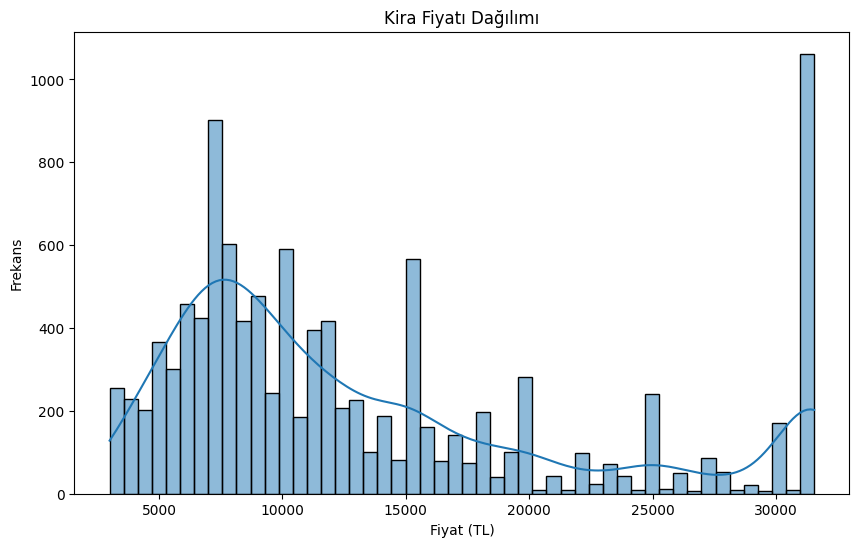

In [37]:
plt.figure(figsize=(10,6))
sns.histplot(df['price_capped'], bins=50, kde=True)
plt.title('Kira Fiyatı Dağılımı')
plt.xlabel('Fiyat (TL)')
plt.ylabel('Frekans')
plt.show()

In [38]:
X = df.drop(['price', 'title', 'Unnamed: 0'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modellemelere başlamadan önce şu anahtar kelimeleri bilmemiz gerekli:

1.   MAE: Tahmnlerin ortalama mutlak hata büyüklüğü
2.   MSE: Hataların karesinin ortalaması
1.   RMSE: MSE'nin karekökü
2.   MAPE: Ortalama yüzde hata
1.   R^2 SKOR: Modelin veriyi açıklama gücü






Linear Regrasyon
-------------------------

In [39]:
# Modeli tanımla
model = LinearRegression()

# Modeli eğit
model.fit(X_train, y_train)

LinearRegression()

In [40]:
y_pred = model.predict(X_test)

In [44]:
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))
print("Linear Regression R2 Score:", r2_score(y_test, y_pred))

Linear Regression MAE: 3875.202576249033
Linear Regression MSE: 109276524.8264728
Linear Regression R2 Score: 0.6635870944789606


In [50]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    mape_lr = mean_absolute_percentage_error(y_test, y_pred)
print(f"Linear Regression MAPE: {mape_lr:.2f}%")

Linear Regression MAPE: 24.29%


Linear Regression modelimiz için değerleri aldık. Bir de Random Forest modeli için bakalım.

Random Forest
-----------------------------

In [42]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest MAE: 1213.4674404246293
Random Forest MSE: 53715233.754115775
Random Forest R2 Score: 0.8346351342462692


In [49]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)


print(f"Random Forest MAPE: {mape_rf:.2f}%")

Random Forest MAPE: 2.00%


Görüldüğü üzere Random Forest modeli daha başarılı sonuç verdi.


1.   MAE değeri, Random Forest'ta çok daha düşük. Yani tahminleri daha hassas.
2.   MSE değeri, Linear Regression'da oldukça yüksek, Random Forest ise daha düşük.
1.   RMSE değerleri için yine random forest daha düşük hata gösteriyor. Bu da tahminlerin ortalama sapması daha az olduğu anlamına geliyor.
Linear Regression için RMSE ≈ 10,453 TL
Ortalama tahmin hatası yaklaşık 10.453 TL civarında. Büyük sapmalar olabilir.
Random Forest için RMSE ≈ 7,331 TL
Daha iyi, ortalama hata yaklaşık 7.331 TL, yani tahminler daha yakından gerçekleşiyor.
2.   MAPE değeri için ise Random Forest sadece %2 hata ile tahmin yapıyor. Linear Regression ise yaklaşık %24 hata ile yani gerçek fiyatın yaklaşık 1/4’ü kadar sapıyor.
1.   R2 skoru, Random Forest'ta daha yüksek. Daha iyi uyum sağlıyor.




